In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../thesis/dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [3]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [4]:
from pyscf.scf import hf
h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

# Utilities 

In [5]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [6]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

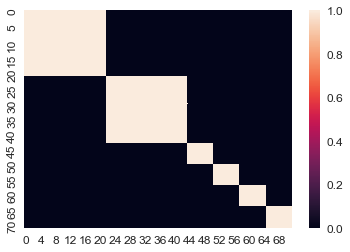

In [7]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [8]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

In [9]:
from pyscf.scf import hf
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [10]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


# GWH 

In [11]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [12]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 01:09:50: Iteration calculation: 0
[ ] 2019-01-07 01:09:52: Iteration calculation: 1
[ ] 2019-01-07 01:09:54: Iteration calculation: 2
[ ] 2019-01-07 01:09:55: Iteration calculation: 3
[ ] 2019-01-07 01:09:57: Iteration calculation: 4
[ ] 2019-01-07 01:09:58: Iteration calculation: 5
[ ] 2019-01-07 01:10:00: Iteration calculation: 6
[ ] 2019-01-07 01:10:01: Iteration calculation: 7
[ ] 2019-01-07 01:10:03: Iteration calculation: 8
[ ] 2019-01-07 01:10:04: Iteration calculation: 9
[ ] 2019-01-07 01:10:05: Iteration calculation: 10
[ ] 2019-01-07 01:10:07: Iteration calculation: 11
[ ] 2019-01-07 01:10:09: Iteration calculation: 12
[ ] 2019-01-07 01:10:12: Iteration calculation: 13
[ ] 2019-01-07 01:10:14: Iteration calculation: 14
[ ] 2019-01-07 01:10:16: Iteration calculation: 15
[ ] 2019-01-07 01:10:17: Iteration calculation: 16
[ ] 2019-01-07 01:10:19: Iteration calculation: 17
[ ] 2019-01-07 01:10:20: Iteration calculation: 18
[ ] 2019-01-07 01:10:22: Iteration calcul

[ ] 2019-01-07 01:13:56: Iteration calculation: 160
[ ] 2019-01-07 01:13:58: Iteration calculation: 161
[ ] 2019-01-07 01:13:59: Iteration calculation: 162
[ ] 2019-01-07 01:14:00: Iteration calculation: 163
[ ] 2019-01-07 01:14:01: Iteration calculation: 164
[ ] 2019-01-07 01:14:02: Iteration calculation: 165
[ ] 2019-01-07 01:14:04: Iteration calculation: 166
[ ] 2019-01-07 01:14:05: Iteration calculation: 167
[ ] 2019-01-07 01:14:08: Iteration calculation: 168
[ ] 2019-01-07 01:14:10: Iteration calculation: 169
[ ] 2019-01-07 01:14:12: Iteration calculation: 170
[ ] 2019-01-07 01:14:14: Iteration calculation: 171
[ ] 2019-01-07 01:14:16: Iteration calculation: 172
[ ] 2019-01-07 01:14:18: Iteration calculation: 173
[ ] 2019-01-07 01:14:19: Iteration calculation: 174
[ ] 2019-01-07 01:14:21: Iteration calculation: 175
[ ] 2019-01-07 01:14:22: Iteration calculation: 176
[ ] 2019-01-07 01:14:24: Iteration calculation: 177
[ ] 2019-01-07 01:14:26: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 01:17:50: Iteration calculation: 318
[ ] 2019-01-07 01:17:51: Iteration calculation: 319
[ ] 2019-01-07 01:17:53: Iteration calculation: 320
[ ] 2019-01-07 01:17:54: Iteration calculation: 321
[ ] 2019-01-07 01:17:56: Iteration calculation: 322
[ ] 2019-01-07 01:17:58: Iteration calculation: 323
[ ] 2019-01-07 01:18:00: Iteration calculation: 324
[ ] 2019-01-07 01:18:01: Iteration calculation: 325
[ ] 2019-01-07 01:18:03: Iteration calculation: 326
[ ] 2019-01-07 01:18:04: Iteration calculation: 327
[ ] 2019-01-07 01:18:06: Iteration calculation: 328
[ ] 2019-01-07 01:18:07: Iteration calculation: 329
[ ] 2019-01-07 01:18:09: Iteration calculation: 330
[ ] 2019-01-07 01:18:10: Iteration calculation: 331
[ ] 2019-01-07 01:18:11: Iteration calculation: 332
[ ] 2019-01-07 01:18:12: Iteration calculation: 333
[ ] 2019-01-07 01:18:14: Iteration calculation: 334
[ ] 2019-01-07 01:18:15: Iteration calculation: 335
[ ] 2019-01-07 01:18:16: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 01:21:40: Iteration calculation: 476
[ ] 2019-01-07 01:21:42: Iteration calculation: 477
[ ] 2019-01-07 01:21:44: Iteration calculation: 478
[ ] 2019-01-07 01:21:46: Iteration calculation: 479
[ ] 2019-01-07 01:21:46: Iteration calculation: 480
[ ] 2019-01-07 01:21:48: Iteration calculation: 481
[ ] 2019-01-07 01:21:49: Iteration calculation: 482
[ ] 2019-01-07 01:21:49: Iteration calculation: 483
[ ] 2019-01-07 01:21:50: Iteration calculation: 484
[ ] 2019-01-07 01:21:52: Iteration calculation: 485
[ ] 2019-01-07 01:21:53: Iteration calculation: 486
[ ] 2019-01-07 01:21:55: Iteration calculation: 487
[ ] 2019-01-07 01:21:56: Iteration calculation: 488
[ ] 2019-01-07 01:21:58: Iteration calculation: 489
[ ] 2019-01-07 01:21:59: Iteration calculation: 490
[ ] 2019-01-07 01:22:02: Iteration calculation: 491
[ ] 2019-01-07 01:22:04: Iteration calculation: 492
[ ] 2019-01-07 01:22:05: Iteration calculation: 493
[ ] 2019-01-07 01:22:06: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 01:25:30: Iteration calculation: 634
[ ] 2019-01-07 01:25:31: Iteration calculation: 635
[ ] 2019-01-07 01:25:32: Iteration calculation: 636
[ ] 2019-01-07 01:25:34: Iteration calculation: 637
[ ] 2019-01-07 01:25:36: Iteration calculation: 638
[ ] 2019-01-07 01:25:37: Iteration calculation: 639
[ ] 2019-01-07 01:25:39: Iteration calculation: 640
[ ] 2019-01-07 01:25:40: Iteration calculation: 641
[ ] 2019-01-07 01:25:41: Iteration calculation: 642
[ ] 2019-01-07 01:25:42: Iteration calculation: 643
[ ] 2019-01-07 01:25:44: Iteration calculation: 644
[ ] 2019-01-07 01:25:45: Iteration calculation: 645
[ ] 2019-01-07 01:25:46: Iteration calculation: 646
[ ] 2019-01-07 01:25:48: Iteration calculation: 647
[ ] 2019-01-07 01:25:49: Iteration calculation: 648
[ ] 2019-01-07 01:25:51: Iteration calculation: 649
[ ] 2019-01-07 01:25:53: Iteration calculation: 650
[ ] 2019-01-07 01:25:54: Iteration calculation: 651
[ ] 2019-01-07 01:25:56: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 01:29:24: Iteration calculation: 792
[ ] 2019-01-07 01:29:26: Iteration calculation: 793
[ ] 2019-01-07 01:29:27: Iteration calculation: 794
[ ] 2019-01-07 01:29:29: Iteration calculation: 795
[ ] 2019-01-07 01:29:29: Iteration calculation: 796
[ ] 2019-01-07 01:29:30: Iteration calculation: 797
[ ] 2019-01-07 01:29:32: Iteration calculation: 798
[ ] 2019-01-07 01:29:34: Iteration calculation: 799
[ ] 2019-01-07 01:29:35: Iteration calculation: 800
[ ] 2019-01-07 01:29:37: Iteration calculation: 801
[ ] 2019-01-07 01:29:38: Iteration calculation: 802
[ ] 2019-01-07 01:29:40: Iteration calculation: 803
[ ] 2019-01-07 01:29:41: Iteration calculation: 804
[ ] 2019-01-07 01:29:44: Iteration calculation: 805
[ ] 2019-01-07 01:29:47: Iteration calculation: 806
[ ] 2019-01-07 01:29:49: Iteration calculation: 807
[ ] 2019-01-07 01:29:51: Iteration calculation: 808
[ ] 2019-01-07 01:29:52: Iteration calculation: 809
[ ] 2019-01-07 01:29:54: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 01:33:27: Iteration calculation: 950
[ ] 2019-01-07 01:33:29: Iteration calculation: 951
[ ] 2019-01-07 01:33:30: Iteration calculation: 952
[ ] 2019-01-07 01:33:31: Iteration calculation: 953
[ ] 2019-01-07 01:33:33: Iteration calculation: 954
[ ] 2019-01-07 01:33:35: Iteration calculation: 955
[ ] 2019-01-07 01:33:36: Iteration calculation: 956
[ ] 2019-01-07 01:33:38: Iteration calculation: 957
[ ] 2019-01-07 01:33:40: Iteration calculation: 958
[ ] 2019-01-07 01:33:40: Iteration calculation: 959
[ ] 2019-01-07 01:33:42: Iteration calculation: 960
[ ] 2019-01-07 01:33:44: Iteration calculation: 961
[ ] 2019-01-07 01:33:45: Iteration calculation: 962
[ ] 2019-01-07 01:33:46: Iteration calculation: 963
[ ] 2019-01-07 01:33:48: Iteration calculation: 964
[ ] 2019-01-07 01:33:49: Iteration calculation: 965
[ ] 2019-01-07 01:33:51: Iteration calculation: 966
[ ] 2019-01-07 01:33:53: Iteration calculation: 967
[ ] 2019-01-07 01:33:54: Iteration calculation: 968
[ ] 2019-01-

# Embedded GWH 

In [13]:
p_embedded_gwh = embedd_batch(p_gwh)

In [14]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 01:41:30: Iteration calculation: 0
[ ] 2019-01-07 01:41:30: Iteration calculation: 1
[ ] 2019-01-07 01:41:31: Iteration calculation: 2
[ ] 2019-01-07 01:41:32: Iteration calculation: 3
[ ] 2019-01-07 01:41:33: Iteration calculation: 4
[ ] 2019-01-07 01:41:34: Iteration calculation: 5
[ ] 2019-01-07 01:41:34: Iteration calculation: 6
[ ] 2019-01-07 01:41:35: Iteration calculation: 7
[ ] 2019-01-07 01:41:35: Iteration calculation: 8
[ ] 2019-01-07 01:41:36: Iteration calculation: 9
[ ] 2019-01-07 01:41:37: Iteration calculation: 10
[ ] 2019-01-07 01:41:37: Iteration calculation: 11
[ ] 2019-01-07 01:41:38: Iteration calculation: 12
[ ] 2019-01-07 01:41:38: Iteration calculation: 13
[ ] 2019-01-07 01:41:39: Iteration calculation: 14
[ ] 2019-01-07 01:41:40: Iteration calculation: 15
[ ] 2019-01-07 01:41:40: Iteration calculation: 16
[ ] 2019-01-07 01:41:41: Iteration calculation: 17
[ ] 2019-01-07 01:41:42: Iteration calculation: 18
[ ] 2019-01-07 01:41:43: Iteration calcul

[ ] 2019-01-07 01:43:40: Iteration calculation: 160
[ ] 2019-01-07 01:43:41: Iteration calculation: 161
[ ] 2019-01-07 01:43:41: Iteration calculation: 162
[ ] 2019-01-07 01:43:42: Iteration calculation: 163
[ ] 2019-01-07 01:43:42: Iteration calculation: 164
[ ] 2019-01-07 01:43:43: Iteration calculation: 165
[ ] 2019-01-07 01:43:44: Iteration calculation: 166
[ ] 2019-01-07 01:43:44: Iteration calculation: 167
[ ] 2019-01-07 01:43:45: Iteration calculation: 168
[ ] 2019-01-07 01:43:45: Iteration calculation: 169
[ ] 2019-01-07 01:43:46: Iteration calculation: 170
[ ] 2019-01-07 01:43:47: Iteration calculation: 171
[ ] 2019-01-07 01:43:47: Iteration calculation: 172
[ ] 2019-01-07 01:43:48: Iteration calculation: 173
[ ] 2019-01-07 01:43:49: Iteration calculation: 174
[ ] 2019-01-07 01:43:50: Iteration calculation: 175
[ ] 2019-01-07 01:43:51: Iteration calculation: 176
[ ] 2019-01-07 01:43:51: Iteration calculation: 177
[ ] 2019-01-07 01:43:52: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 01:45:37: Iteration calculation: 318
[ ] 2019-01-07 01:45:37: Iteration calculation: 319
[ ] 2019-01-07 01:45:38: Iteration calculation: 320
[ ] 2019-01-07 01:45:38: Iteration calculation: 321
[ ] 2019-01-07 01:45:39: Iteration calculation: 322
[ ] 2019-01-07 01:45:39: Iteration calculation: 323
[ ] 2019-01-07 01:45:40: Iteration calculation: 324
[ ] 2019-01-07 01:45:40: Iteration calculation: 325
[ ] 2019-01-07 01:45:41: Iteration calculation: 326
[ ] 2019-01-07 01:45:42: Iteration calculation: 327
[ ] 2019-01-07 01:45:42: Iteration calculation: 328
[ ] 2019-01-07 01:45:43: Iteration calculation: 329
[ ] 2019-01-07 01:45:44: Iteration calculation: 330
[ ] 2019-01-07 01:45:44: Iteration calculation: 331
[ ] 2019-01-07 01:45:45: Iteration calculation: 332
[ ] 2019-01-07 01:45:45: Iteration calculation: 333
[ ] 2019-01-07 01:45:46: Iteration calculation: 334
[ ] 2019-01-07 01:45:47: Iteration calculation: 335
[ ] 2019-01-07 01:45:47: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 01:47:41: Iteration calculation: 476
[ ] 2019-01-07 01:47:42: Iteration calculation: 477
[ ] 2019-01-07 01:47:43: Iteration calculation: 478
[ ] 2019-01-07 01:47:44: Iteration calculation: 479
[ ] 2019-01-07 01:47:45: Iteration calculation: 480
[ ] 2019-01-07 01:47:46: Iteration calculation: 481
[ ] 2019-01-07 01:47:47: Iteration calculation: 482
[ ] 2019-01-07 01:47:48: Iteration calculation: 483
[ ] 2019-01-07 01:47:49: Iteration calculation: 484
[ ] 2019-01-07 01:47:49: Iteration calculation: 485
[ ] 2019-01-07 01:47:50: Iteration calculation: 486
[ ] 2019-01-07 01:47:51: Iteration calculation: 487
[ ] 2019-01-07 01:47:51: Iteration calculation: 488
[ ] 2019-01-07 01:47:52: Iteration calculation: 489
[ ] 2019-01-07 01:47:52: Iteration calculation: 490
[ ] 2019-01-07 01:47:54: Iteration calculation: 491
[ ] 2019-01-07 01:47:56: Iteration calculation: 492
[ ] 2019-01-07 01:47:56: Iteration calculation: 493
[ ] 2019-01-07 01:47:58: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 01:49:46: Iteration calculation: 634
[ ] 2019-01-07 01:49:47: Iteration calculation: 635
[ ] 2019-01-07 01:49:47: Iteration calculation: 636
[ ] 2019-01-07 01:49:49: Iteration calculation: 637
[ ] 2019-01-07 01:49:49: Iteration calculation: 638
[ ] 2019-01-07 01:49:50: Iteration calculation: 639
[ ] 2019-01-07 01:49:50: Iteration calculation: 640
[ ] 2019-01-07 01:49:51: Iteration calculation: 641
[ ] 2019-01-07 01:49:52: Iteration calculation: 642
[ ] 2019-01-07 01:49:53: Iteration calculation: 643
[ ] 2019-01-07 01:49:55: Iteration calculation: 644
[ ] 2019-01-07 01:49:56: Iteration calculation: 645
[ ] 2019-01-07 01:49:57: Iteration calculation: 646
[ ] 2019-01-07 01:49:57: Iteration calculation: 647
[ ] 2019-01-07 01:49:58: Iteration calculation: 648
[ ] 2019-01-07 01:49:59: Iteration calculation: 649
[ ] 2019-01-07 01:50:02: Iteration calculation: 650
[ ] 2019-01-07 01:50:03: Iteration calculation: 651
[ ] 2019-01-07 01:50:03: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 01:51:51: Iteration calculation: 792
[ ] 2019-01-07 01:51:52: Iteration calculation: 793
[ ] 2019-01-07 01:51:52: Iteration calculation: 794
[ ] 2019-01-07 01:51:53: Iteration calculation: 795
[ ] 2019-01-07 01:51:53: Iteration calculation: 796
[ ] 2019-01-07 01:51:54: Iteration calculation: 797
[ ] 2019-01-07 01:51:55: Iteration calculation: 798
[ ] 2019-01-07 01:51:56: Iteration calculation: 799
[ ] 2019-01-07 01:51:56: Iteration calculation: 800
[ ] 2019-01-07 01:51:57: Iteration calculation: 801
[ ] 2019-01-07 01:51:58: Iteration calculation: 802
[ ] 2019-01-07 01:51:58: Iteration calculation: 803
[ ] 2019-01-07 01:51:59: Iteration calculation: 804
[ ] 2019-01-07 01:52:00: Iteration calculation: 805
[ ] 2019-01-07 01:52:01: Iteration calculation: 806
[ ] 2019-01-07 01:52:02: Iteration calculation: 807
[ ] 2019-01-07 01:52:03: Iteration calculation: 808
[ ] 2019-01-07 01:52:03: Iteration calculation: 809
[ ] 2019-01-07 01:52:04: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 01:53:47: Iteration calculation: 950
[ ] 2019-01-07 01:53:47: Iteration calculation: 951
[ ] 2019-01-07 01:53:48: Iteration calculation: 952
[ ] 2019-01-07 01:53:49: Iteration calculation: 953
[ ] 2019-01-07 01:53:49: Iteration calculation: 954
[ ] 2019-01-07 01:53:50: Iteration calculation: 955
[ ] 2019-01-07 01:53:52: Iteration calculation: 956
[ ] 2019-01-07 01:53:52: Iteration calculation: 957
[ ] 2019-01-07 01:53:53: Iteration calculation: 958
[ ] 2019-01-07 01:53:53: Iteration calculation: 959
[ ] 2019-01-07 01:53:54: Iteration calculation: 960
[ ] 2019-01-07 01:53:55: Iteration calculation: 961
[ ] 2019-01-07 01:53:55: Iteration calculation: 962
[ ] 2019-01-07 01:53:56: Iteration calculation: 963
[ ] 2019-01-07 01:53:58: Iteration calculation: 964
[ ] 2019-01-07 01:53:58: Iteration calculation: 965
[ ] 2019-01-07 01:53:59: Iteration calculation: 966
[ ] 2019-01-07 01:53:59: Iteration calculation: 967
[ ] 2019-01-07 01:54:00: Iteration calculation: 968
[ ] 2019-01-

In [15]:
51/1001

0.05094905094905095

# Embedded GWH + 1 Iteration

In [16]:
f_embedded_gwh = fock_from_density_batch(p_embedded_gwh)
p_embedded_gwh_test = density_from_fock_batch(f_embedded_gwh)

In [17]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 02:06:02: Iteration calculation: 0
[ ] 2019-01-07 02:06:03: Iteration calculation: 1
[ ] 2019-01-07 02:06:04: Iteration calculation: 2
[ ] 2019-01-07 02:06:05: Iteration calculation: 3
[ ] 2019-01-07 02:06:06: Iteration calculation: 4
[ ] 2019-01-07 02:06:06: Iteration calculation: 5
[ ] 2019-01-07 02:06:07: Iteration calculation: 6
[ ] 2019-01-07 02:06:08: Iteration calculation: 7
[ ] 2019-01-07 02:06:08: Iteration calculation: 8
[ ] 2019-01-07 02:06:09: Iteration calculation: 9
[ ] 2019-01-07 02:06:09: Iteration calculation: 10
[ ] 2019-01-07 02:06:10: Iteration calculation: 11
[ ] 2019-01-07 02:06:10: Iteration calculation: 12
[ ] 2019-01-07 02:06:11: Iteration calculation: 13
[ ] 2019-01-07 02:06:12: Iteration calculation: 14
[ ] 2019-01-07 02:06:12: Iteration calculation: 15
[ ] 2019-01-07 02:06:13: Iteration calculation: 16
[ ] 2019-01-07 02:06:14: Iteration calculation: 17
[ ] 2019-01-07 02:06:15: Iteration calculation: 18
[ ] 2019-01-07 02:06:15: Iteration calcul

[ ] 2019-01-07 02:08:03: Iteration calculation: 160
[ ] 2019-01-07 02:08:04: Iteration calculation: 161
[ ] 2019-01-07 02:08:05: Iteration calculation: 162
[ ] 2019-01-07 02:08:05: Iteration calculation: 163
[ ] 2019-01-07 02:08:06: Iteration calculation: 164
[ ] 2019-01-07 02:08:07: Iteration calculation: 165
[ ] 2019-01-07 02:08:07: Iteration calculation: 166
[ ] 2019-01-07 02:08:08: Iteration calculation: 167
[ ] 2019-01-07 02:08:09: Iteration calculation: 168
[ ] 2019-01-07 02:08:09: Iteration calculation: 169
[ ] 2019-01-07 02:08:10: Iteration calculation: 170
[ ] 2019-01-07 02:08:11: Iteration calculation: 171
[ ] 2019-01-07 02:08:11: Iteration calculation: 172
[ ] 2019-01-07 02:08:12: Iteration calculation: 173
[ ] 2019-01-07 02:08:12: Iteration calculation: 174
[ ] 2019-01-07 02:08:14: Iteration calculation: 175
[ ] 2019-01-07 02:08:14: Iteration calculation: 176
[ ] 2019-01-07 02:08:15: Iteration calculation: 177
[ ] 2019-01-07 02:08:15: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 02:09:57: Iteration calculation: 318
[ ] 2019-01-07 02:09:58: Iteration calculation: 319
[ ] 2019-01-07 02:09:58: Iteration calculation: 320
[ ] 2019-01-07 02:09:59: Iteration calculation: 321
[ ] 2019-01-07 02:09:59: Iteration calculation: 322
[ ] 2019-01-07 02:10:00: Iteration calculation: 323
[ ] 2019-01-07 02:10:00: Iteration calculation: 324
[ ] 2019-01-07 02:10:01: Iteration calculation: 325
[ ] 2019-01-07 02:10:01: Iteration calculation: 326
[ ] 2019-01-07 02:10:02: Iteration calculation: 327
[ ] 2019-01-07 02:10:02: Iteration calculation: 328
[ ] 2019-01-07 02:10:03: Iteration calculation: 329
[ ] 2019-01-07 02:10:03: Iteration calculation: 330
[ ] 2019-01-07 02:10:04: Iteration calculation: 331
[ ] 2019-01-07 02:10:05: Iteration calculation: 332
[ ] 2019-01-07 02:10:05: Iteration calculation: 333
[ ] 2019-01-07 02:10:06: Iteration calculation: 334
[ ] 2019-01-07 02:10:06: Iteration calculation: 335
[ ] 2019-01-07 02:10:07: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 02:11:58: Iteration calculation: 476
[ ] 2019-01-07 02:11:59: Iteration calculation: 477
[ ] 2019-01-07 02:12:00: Iteration calculation: 478
[ ] 2019-01-07 02:12:00: Iteration calculation: 479
[ ] 2019-01-07 02:12:01: Iteration calculation: 480
[ ] 2019-01-07 02:12:02: Iteration calculation: 481
[ ] 2019-01-07 02:12:02: Iteration calculation: 482
[ ] 2019-01-07 02:12:03: Iteration calculation: 483
[ ] 2019-01-07 02:12:03: Iteration calculation: 484
[ ] 2019-01-07 02:12:04: Iteration calculation: 485
[ ] 2019-01-07 02:12:04: Iteration calculation: 486
[ ] 2019-01-07 02:12:05: Iteration calculation: 487
[ ] 2019-01-07 02:12:05: Iteration calculation: 488
[ ] 2019-01-07 02:12:06: Iteration calculation: 489
[ ] 2019-01-07 02:12:06: Iteration calculation: 490
[ ] 2019-01-07 02:12:08: Iteration calculation: 491
[ ] 2019-01-07 02:12:10: Iteration calculation: 492
[ ] 2019-01-07 02:12:10: Iteration calculation: 493
[ ] 2019-01-07 02:12:12: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 02:13:56: Iteration calculation: 634
[ ] 2019-01-07 02:13:56: Iteration calculation: 635
[ ] 2019-01-07 02:13:57: Iteration calculation: 636
[ ] 2019-01-07 02:13:58: Iteration calculation: 637
[ ] 2019-01-07 02:13:59: Iteration calculation: 638
[ ] 2019-01-07 02:13:59: Iteration calculation: 639
[ ] 2019-01-07 02:14:00: Iteration calculation: 640
[ ] 2019-01-07 02:14:00: Iteration calculation: 641
[ ] 2019-01-07 02:14:01: Iteration calculation: 642
[ ] 2019-01-07 02:14:01: Iteration calculation: 643
[ ] 2019-01-07 02:14:02: Iteration calculation: 644
[ ] 2019-01-07 02:14:03: Iteration calculation: 645
[ ] 2019-01-07 02:14:04: Iteration calculation: 646
[ ] 2019-01-07 02:14:04: Iteration calculation: 647
[ ] 2019-01-07 02:14:04: Iteration calculation: 648
[ ] 2019-01-07 02:14:05: Iteration calculation: 649
[ ] 2019-01-07 02:14:07: Iteration calculation: 650
[ ] 2019-01-07 02:14:08: Iteration calculation: 651
[ ] 2019-01-07 02:14:08: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 02:15:54: Iteration calculation: 792
[ ] 2019-01-07 02:15:55: Iteration calculation: 793
[ ] 2019-01-07 02:15:56: Iteration calculation: 794
[ ] 2019-01-07 02:15:56: Iteration calculation: 795
[ ] 2019-01-07 02:15:57: Iteration calculation: 796
[ ] 2019-01-07 02:15:57: Iteration calculation: 797
[ ] 2019-01-07 02:15:58: Iteration calculation: 798
[ ] 2019-01-07 02:15:59: Iteration calculation: 799
[ ] 2019-01-07 02:15:59: Iteration calculation: 800
[ ] 2019-01-07 02:16:00: Iteration calculation: 801
[ ] 2019-01-07 02:16:01: Iteration calculation: 802
[ ] 2019-01-07 02:16:01: Iteration calculation: 803
[ ] 2019-01-07 02:16:02: Iteration calculation: 804
[ ] 2019-01-07 02:16:03: Iteration calculation: 805
[ ] 2019-01-07 02:16:04: Iteration calculation: 806
[ ] 2019-01-07 02:16:05: Iteration calculation: 807
[ ] 2019-01-07 02:16:05: Iteration calculation: 808
[ ] 2019-01-07 02:16:06: Iteration calculation: 809
[ ] 2019-01-07 02:16:07: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 02:17:49: Iteration calculation: 950
[ ] 2019-01-07 02:17:49: Iteration calculation: 951
[ ] 2019-01-07 02:17:50: Iteration calculation: 952
[ ] 2019-01-07 02:17:51: Iteration calculation: 953
[ ] 2019-01-07 02:17:51: Iteration calculation: 954
[ ] 2019-01-07 02:17:52: Iteration calculation: 955
[ ] 2019-01-07 02:17:53: Iteration calculation: 956
[ ] 2019-01-07 02:17:54: Iteration calculation: 957
[ ] 2019-01-07 02:17:54: Iteration calculation: 958
[ ] 2019-01-07 02:17:55: Iteration calculation: 959
[ ] 2019-01-07 02:17:55: Iteration calculation: 960
[ ] 2019-01-07 02:17:56: Iteration calculation: 961
[ ] 2019-01-07 02:17:57: Iteration calculation: 962
[ ] 2019-01-07 02:17:57: Iteration calculation: 963
[ ] 2019-01-07 02:17:59: Iteration calculation: 964
[ ] 2019-01-07 02:18:00: Iteration calculation: 965
[ ] 2019-01-07 02:18:00: Iteration calculation: 966
[ ] 2019-01-07 02:18:01: Iteration calculation: 967
[ ] 2019-01-07 02:18:01: Iteration calculation: 968
[ ] 2019-01-

In [20]:
51/1001

0.05094905094905095

# SAD 

In [18]:
from pyscf.scf import hf

p_sad = np.array([ 
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

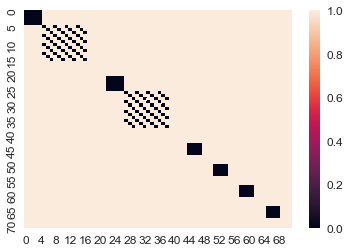

In [19]:
sns.heatmap((abs(p_sad[0]) < 1e-12).astype("int"))

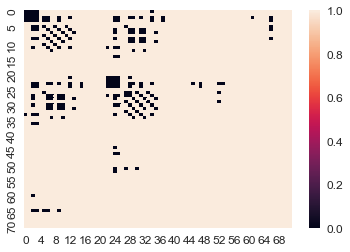

In [20]:
sns.heatmap((abs(p_gwh[0]) < 0.05).astype("int"))

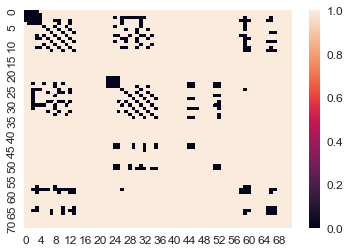

In [21]:
sns.heatmap((abs(p_test[30]) < 0.05).astype("int"))

In [22]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 02:27:21: Iteration calculation: 0
[ ] 2019-01-07 02:27:22: Iteration calculation: 1
[ ] 2019-01-07 02:27:23: Iteration calculation: 2
[ ] 2019-01-07 02:27:24: Iteration calculation: 3
[ ] 2019-01-07 02:27:24: Iteration calculation: 4
[ ] 2019-01-07 02:27:25: Iteration calculation: 5
[ ] 2019-01-07 02:27:26: Iteration calculation: 6
[ ] 2019-01-07 02:27:27: Iteration calculation: 7
[ ] 2019-01-07 02:27:28: Iteration calculation: 8
[ ] 2019-01-07 02:27:29: Iteration calculation: 9
[ ] 2019-01-07 02:27:31: Iteration calculation: 10
[ ] 2019-01-07 02:27:32: Iteration calculation: 11
[ ] 2019-01-07 02:27:32: Iteration calculation: 12
[ ] 2019-01-07 02:27:33: Iteration calculation: 13
[ ] 2019-01-07 02:27:34: Iteration calculation: 14
[ ] 2019-01-07 02:27:34: Iteration calculation: 15
[ ] 2019-01-07 02:27:35: Iteration calculation: 16
[ ] 2019-01-07 02:27:36: Iteration calculation: 17
[ ] 2019-01-07 02:27:36: Iteration calculation: 18
[ ] 2019-01-07 02:27:37: Iteration calcul

[ ] 2019-01-07 02:29:25: Iteration calculation: 160
[ ] 2019-01-07 02:29:27: Iteration calculation: 161
[ ] 2019-01-07 02:29:27: Iteration calculation: 162
[ ] 2019-01-07 02:29:28: Iteration calculation: 163
[ ] 2019-01-07 02:29:28: Iteration calculation: 164
[ ] 2019-01-07 02:29:29: Iteration calculation: 165
[ ] 2019-01-07 02:29:30: Iteration calculation: 166
[ ] 2019-01-07 02:29:30: Iteration calculation: 167
[ ] 2019-01-07 02:29:30: Iteration calculation: 168
[ ] 2019-01-07 02:29:31: Iteration calculation: 169
[ ] 2019-01-07 02:29:32: Iteration calculation: 170
[ ] 2019-01-07 02:29:32: Iteration calculation: 171
[ ] 2019-01-07 02:29:33: Iteration calculation: 172
[ ] 2019-01-07 02:29:34: Iteration calculation: 173
[ ] 2019-01-07 02:29:34: Iteration calculation: 174
[ ] 2019-01-07 02:29:36: Iteration calculation: 175
[ ] 2019-01-07 02:29:36: Iteration calculation: 176
[ ] 2019-01-07 02:29:37: Iteration calculation: 177
[ ] 2019-01-07 02:29:37: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 02:31:18: Iteration calculation: 318
[ ] 2019-01-07 02:31:18: Iteration calculation: 319
[ ] 2019-01-07 02:31:19: Iteration calculation: 320
[ ] 2019-01-07 02:31:20: Iteration calculation: 321
[ ] 2019-01-07 02:31:20: Iteration calculation: 322
[ ] 2019-01-07 02:31:20: Iteration calculation: 323
[ ] 2019-01-07 02:31:21: Iteration calculation: 324
[ ] 2019-01-07 02:31:21: Iteration calculation: 325
[ ] 2019-01-07 02:31:22: Iteration calculation: 326
[ ] 2019-01-07 02:31:23: Iteration calculation: 327
[ ] 2019-01-07 02:31:23: Iteration calculation: 328
[ ] 2019-01-07 02:31:24: Iteration calculation: 329
[ ] 2019-01-07 02:31:25: Iteration calculation: 330
[ ] 2019-01-07 02:31:25: Iteration calculation: 331
[ ] 2019-01-07 02:31:26: Iteration calculation: 332
[ ] 2019-01-07 02:31:26: Iteration calculation: 333
[ ] 2019-01-07 02:31:27: Iteration calculation: 334
[ ] 2019-01-07 02:31:27: Iteration calculation: 335
[ ] 2019-01-07 02:31:28: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 02:33:18: Iteration calculation: 476
[ ] 2019-01-07 02:33:19: Iteration calculation: 477
[ ] 2019-01-07 02:33:19: Iteration calculation: 478
[ ] 2019-01-07 02:33:20: Iteration calculation: 479
[ ] 2019-01-07 02:33:20: Iteration calculation: 480
[ ] 2019-01-07 02:33:21: Iteration calculation: 481
[ ] 2019-01-07 02:33:22: Iteration calculation: 482
[ ] 2019-01-07 02:33:23: Iteration calculation: 483
[ ] 2019-01-07 02:33:24: Iteration calculation: 484
[ ] 2019-01-07 02:33:25: Iteration calculation: 485
[ ] 2019-01-07 02:33:25: Iteration calculation: 486
[ ] 2019-01-07 02:33:26: Iteration calculation: 487
[ ] 2019-01-07 02:33:27: Iteration calculation: 488
[ ] 2019-01-07 02:33:27: Iteration calculation: 489
[ ] 2019-01-07 02:33:28: Iteration calculation: 490
[ ] 2019-01-07 02:33:30: Iteration calculation: 491
[ ] 2019-01-07 02:33:31: Iteration calculation: 492
[ ] 2019-01-07 02:33:32: Iteration calculation: 493
[ ] 2019-01-07 02:33:33: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 02:35:17: Iteration calculation: 634
[ ] 2019-01-07 02:35:17: Iteration calculation: 635
[ ] 2019-01-07 02:35:18: Iteration calculation: 636
[ ] 2019-01-07 02:35:19: Iteration calculation: 637
[ ] 2019-01-07 02:35:19: Iteration calculation: 638
[ ] 2019-01-07 02:35:20: Iteration calculation: 639
[ ] 2019-01-07 02:35:20: Iteration calculation: 640
[ ] 2019-01-07 02:35:21: Iteration calculation: 641
[ ] 2019-01-07 02:35:21: Iteration calculation: 642
[ ] 2019-01-07 02:35:22: Iteration calculation: 643
[ ] 2019-01-07 02:35:23: Iteration calculation: 644
[ ] 2019-01-07 02:35:23: Iteration calculation: 645
[ ] 2019-01-07 02:35:24: Iteration calculation: 646
[ ] 2019-01-07 02:35:24: Iteration calculation: 647
[ ] 2019-01-07 02:35:25: Iteration calculation: 648
[ ] 2019-01-07 02:35:26: Iteration calculation: 649
[ ] 2019-01-07 02:35:27: Iteration calculation: 650
[ ] 2019-01-07 02:35:28: Iteration calculation: 651
[ ] 2019-01-07 02:35:28: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 02:37:13: Iteration calculation: 792
[ ] 2019-01-07 02:37:14: Iteration calculation: 793
[ ] 2019-01-07 02:37:14: Iteration calculation: 794
[ ] 2019-01-07 02:37:15: Iteration calculation: 795
[ ] 2019-01-07 02:37:15: Iteration calculation: 796
[ ] 2019-01-07 02:37:16: Iteration calculation: 797
[ ] 2019-01-07 02:37:16: Iteration calculation: 798
[ ] 2019-01-07 02:37:17: Iteration calculation: 799
[ ] 2019-01-07 02:37:18: Iteration calculation: 800
[ ] 2019-01-07 02:37:18: Iteration calculation: 801
[ ] 2019-01-07 02:37:19: Iteration calculation: 802
[ ] 2019-01-07 02:37:20: Iteration calculation: 803
[ ] 2019-01-07 02:37:21: Iteration calculation: 804
[ ] 2019-01-07 02:37:21: Iteration calculation: 805
[ ] 2019-01-07 02:37:22: Iteration calculation: 806
[ ] 2019-01-07 02:37:23: Iteration calculation: 807
[ ] 2019-01-07 02:37:23: Iteration calculation: 808
[ ] 2019-01-07 02:37:24: Iteration calculation: 809
[ ] 2019-01-07 02:37:24: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 02:38:59: Iteration calculation: 950
[ ] 2019-01-07 02:38:59: Iteration calculation: 951
[ ] 2019-01-07 02:39:00: Iteration calculation: 952
[ ] 2019-01-07 02:39:00: Iteration calculation: 953
[ ] 2019-01-07 02:39:01: Iteration calculation: 954
[ ] 2019-01-07 02:39:02: Iteration calculation: 955
[ ] 2019-01-07 02:39:04: Iteration calculation: 956
[ ] 2019-01-07 02:39:05: Iteration calculation: 957
[ ] 2019-01-07 02:39:06: Iteration calculation: 958
[ ] 2019-01-07 02:39:06: Iteration calculation: 959
[ ] 2019-01-07 02:39:07: Iteration calculation: 960
[ ] 2019-01-07 02:39:08: Iteration calculation: 961
[ ] 2019-01-07 02:39:09: Iteration calculation: 962
[ ] 2019-01-07 02:39:09: Iteration calculation: 963
[ ] 2019-01-07 02:39:11: Iteration calculation: 964
[ ] 2019-01-07 02:39:12: Iteration calculation: 965
[ ] 2019-01-07 02:39:12: Iteration calculation: 966
[ ] 2019-01-07 02:39:13: Iteration calculation: 967
[ ] 2019-01-07 02:39:13: Iteration calculation: 968
[ ] 2019-01-

In [23]:
47/1001

0.04695304695304695

# Embedded zeros 

In [24]:
p_embedded_zeros = embedd_batch(np.zeros(p_test.shape))

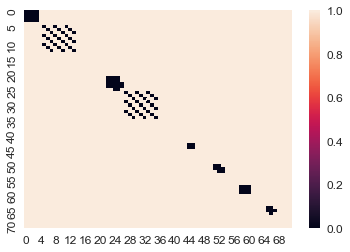

In [25]:
sns.heatmap((abs(p_embedded_zeros[0]) < 0.05).astype("int"))

In [26]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_zeros,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 02:46:47: Iteration calculation: 0
[ ] 2019-01-07 02:46:48: Iteration calculation: 1
[ ] 2019-01-07 02:46:48: Iteration calculation: 2
[ ] 2019-01-07 02:46:50: Iteration calculation: 3
[ ] 2019-01-07 02:46:51: Iteration calculation: 4
[ ] 2019-01-07 02:46:52: Iteration calculation: 5
[ ] 2019-01-07 02:46:52: Iteration calculation: 6
[ ] 2019-01-07 02:46:53: Iteration calculation: 7
[ ] 2019-01-07 02:46:54: Iteration calculation: 8
[ ] 2019-01-07 02:46:55: Iteration calculation: 9
[ ] 2019-01-07 02:46:56: Iteration calculation: 10
[ ] 2019-01-07 02:46:57: Iteration calculation: 11
[ ] 2019-01-07 02:46:57: Iteration calculation: 12
[ ] 2019-01-07 02:46:58: Iteration calculation: 13
[ ] 2019-01-07 02:46:58: Iteration calculation: 14
[ ] 2019-01-07 02:46:59: Iteration calculation: 15
[ ] 2019-01-07 02:47:00: Iteration calculation: 16
[ ] 2019-01-07 02:47:00: Iteration calculation: 17
[ ] 2019-01-07 02:47:02: Iteration calculation: 18
[ ] 2019-01-07 02:47:03: Iteration calcul

[ ] 2019-01-07 02:49:04: Iteration calculation: 160
[ ] 2019-01-07 02:49:05: Iteration calculation: 161
[ ] 2019-01-07 02:49:05: Iteration calculation: 162
[ ] 2019-01-07 02:49:06: Iteration calculation: 163
[ ] 2019-01-07 02:49:06: Iteration calculation: 164
[ ] 2019-01-07 02:49:07: Iteration calculation: 165
[ ] 2019-01-07 02:49:08: Iteration calculation: 166
[ ] 2019-01-07 02:49:08: Iteration calculation: 167
[ ] 2019-01-07 02:49:08: Iteration calculation: 168
[ ] 2019-01-07 02:49:09: Iteration calculation: 169
[ ] 2019-01-07 02:49:10: Iteration calculation: 170
[ ] 2019-01-07 02:49:11: Iteration calculation: 171
[ ] 2019-01-07 02:49:12: Iteration calculation: 172
[ ] 2019-01-07 02:49:13: Iteration calculation: 173
[ ] 2019-01-07 02:49:13: Iteration calculation: 174
[ ] 2019-01-07 02:49:15: Iteration calculation: 175
[ ] 2019-01-07 02:49:15: Iteration calculation: 176
[ ] 2019-01-07 02:49:16: Iteration calculation: 177
[ ] 2019-01-07 02:49:16: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 02:51:06: Iteration calculation: 318
[ ] 2019-01-07 02:51:07: Iteration calculation: 319
[ ] 2019-01-07 02:51:07: Iteration calculation: 320
[ ] 2019-01-07 02:51:08: Iteration calculation: 321
[ ] 2019-01-07 02:51:09: Iteration calculation: 322
[ ] 2019-01-07 02:51:09: Iteration calculation: 323
[ ] 2019-01-07 02:51:10: Iteration calculation: 324
[ ] 2019-01-07 02:51:10: Iteration calculation: 325
[ ] 2019-01-07 02:51:11: Iteration calculation: 326
[ ] 2019-01-07 02:51:12: Iteration calculation: 327
[ ] 2019-01-07 02:51:13: Iteration calculation: 328
[ ] 2019-01-07 02:51:13: Iteration calculation: 329
[ ] 2019-01-07 02:51:14: Iteration calculation: 330
[ ] 2019-01-07 02:51:15: Iteration calculation: 331
[ ] 2019-01-07 02:51:15: Iteration calculation: 332
[ ] 2019-01-07 02:51:16: Iteration calculation: 333
[ ] 2019-01-07 02:51:17: Iteration calculation: 334
[ ] 2019-01-07 02:51:17: Iteration calculation: 335
[ ] 2019-01-07 02:51:18: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 02:53:13: Iteration calculation: 476
[ ] 2019-01-07 02:53:14: Iteration calculation: 477
[ ] 2019-01-07 02:53:15: Iteration calculation: 478
[ ] 2019-01-07 02:53:16: Iteration calculation: 479
[ ] 2019-01-07 02:53:16: Iteration calculation: 480
[ ] 2019-01-07 02:53:17: Iteration calculation: 481
[ ] 2019-01-07 02:53:17: Iteration calculation: 482
[ ] 2019-01-07 02:53:18: Iteration calculation: 483
[ ] 2019-01-07 02:53:18: Iteration calculation: 484
[ ] 2019-01-07 02:53:19: Iteration calculation: 485
[ ] 2019-01-07 02:53:19: Iteration calculation: 486
[ ] 2019-01-07 02:53:20: Iteration calculation: 487
[ ] 2019-01-07 02:53:21: Iteration calculation: 488
[ ] 2019-01-07 02:53:21: Iteration calculation: 489
[ ] 2019-01-07 02:53:22: Iteration calculation: 490
[ ] 2019-01-07 02:53:24: Iteration calculation: 491
[ ] 2019-01-07 02:53:27: Iteration calculation: 492
[ ] 2019-01-07 02:53:27: Iteration calculation: 493
[ ] 2019-01-07 02:53:29: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 02:55:20: Iteration calculation: 634
[ ] 2019-01-07 02:55:21: Iteration calculation: 635
[ ] 2019-01-07 02:55:23: Iteration calculation: 636
[ ] 2019-01-07 02:55:24: Iteration calculation: 637
[ ] 2019-01-07 02:55:25: Iteration calculation: 638
[ ] 2019-01-07 02:55:26: Iteration calculation: 639
[ ] 2019-01-07 02:55:27: Iteration calculation: 640
[ ] 2019-01-07 02:55:27: Iteration calculation: 641
[ ] 2019-01-07 02:55:28: Iteration calculation: 642
[ ] 2019-01-07 02:55:29: Iteration calculation: 643
[ ] 2019-01-07 02:55:30: Iteration calculation: 644
[ ] 2019-01-07 02:55:30: Iteration calculation: 645
[ ] 2019-01-07 02:55:31: Iteration calculation: 646
[ ] 2019-01-07 02:55:32: Iteration calculation: 647
[ ] 2019-01-07 02:55:32: Iteration calculation: 648
[ ] 2019-01-07 02:55:33: Iteration calculation: 649
[ ] 2019-01-07 02:55:34: Iteration calculation: 650
[ ] 2019-01-07 02:55:35: Iteration calculation: 651
[ ] 2019-01-07 02:55:36: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 02:57:30: Iteration calculation: 792
[ ] 2019-01-07 02:57:32: Iteration calculation: 793
[ ] 2019-01-07 02:57:33: Iteration calculation: 794
[ ] 2019-01-07 02:57:34: Iteration calculation: 795
[ ] 2019-01-07 02:57:34: Iteration calculation: 796
[ ] 2019-01-07 02:57:35: Iteration calculation: 797
[ ] 2019-01-07 02:57:38: Iteration calculation: 798
[ ] 2019-01-07 02:57:39: Iteration calculation: 799
[ ] 2019-01-07 02:57:40: Iteration calculation: 800
[ ] 2019-01-07 02:57:41: Iteration calculation: 801
[ ] 2019-01-07 02:57:42: Iteration calculation: 802
[ ] 2019-01-07 02:57:43: Iteration calculation: 803
[ ] 2019-01-07 02:57:44: Iteration calculation: 804
[ ] 2019-01-07 02:57:45: Iteration calculation: 805
[ ] 2019-01-07 02:57:46: Iteration calculation: 806
[ ] 2019-01-07 02:57:47: Iteration calculation: 807
[ ] 2019-01-07 02:57:47: Iteration calculation: 808
[ ] 2019-01-07 02:57:48: Iteration calculation: 809
[ ] 2019-01-07 02:57:49: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 02:59:35: Iteration calculation: 950
[ ] 2019-01-07 02:59:36: Iteration calculation: 951
[ ] 2019-01-07 02:59:37: Iteration calculation: 952
[ ] 2019-01-07 02:59:38: Iteration calculation: 953
[ ] 2019-01-07 02:59:39: Iteration calculation: 954
[ ] 2019-01-07 02:59:39: Iteration calculation: 955
[ ] 2019-01-07 02:59:41: Iteration calculation: 956
[ ] 2019-01-07 02:59:42: Iteration calculation: 957
[ ] 2019-01-07 02:59:42: Iteration calculation: 958
[ ] 2019-01-07 02:59:43: Iteration calculation: 959
[ ] 2019-01-07 02:59:43: Iteration calculation: 960
[ ] 2019-01-07 02:59:44: Iteration calculation: 961
[ ] 2019-01-07 02:59:45: Iteration calculation: 962
[ ] 2019-01-07 02:59:45: Iteration calculation: 963
[ ] 2019-01-07 02:59:46: Iteration calculation: 964
[ ] 2019-01-07 02:59:47: Iteration calculation: 965
[ ] 2019-01-07 02:59:47: Iteration calculation: 966
[ ] 2019-01-07 02:59:48: Iteration calculation: 967
[ ] 2019-01-07 02:59:49: Iteration calculation: 968
[ ] 2019-01-

# Embedded zeros + 1 Iteration? 

In [27]:
f_embedded_zeros = fock_from_density_batch(p_embedded_zeros)
p_embedded_zeros_test = density_from_fock_batch(f_embedded_zeros,)

In [28]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_embedded_zeros_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 03:12:09: Iteration calculation: 0
[ ] 2019-01-07 03:12:09: Iteration calculation: 1
[ ] 2019-01-07 03:12:10: Iteration calculation: 2
[ ] 2019-01-07 03:12:11: Iteration calculation: 3
[ ] 2019-01-07 03:12:14: Iteration calculation: 4
[ ] 2019-01-07 03:12:15: Iteration calculation: 5
[ ] 2019-01-07 03:12:16: Iteration calculation: 6
[ ] 2019-01-07 03:12:17: Iteration calculation: 7
[ ] 2019-01-07 03:12:19: Iteration calculation: 8
[ ] 2019-01-07 03:12:20: Iteration calculation: 9
[ ] 2019-01-07 03:12:21: Iteration calculation: 10
[ ] 2019-01-07 03:12:21: Iteration calculation: 11
[ ] 2019-01-07 03:12:22: Iteration calculation: 12
[ ] 2019-01-07 03:12:22: Iteration calculation: 13
[ ] 2019-01-07 03:12:23: Iteration calculation: 14
[ ] 2019-01-07 03:12:24: Iteration calculation: 15
[ ] 2019-01-07 03:12:25: Iteration calculation: 16
[ ] 2019-01-07 03:12:25: Iteration calculation: 17
[ ] 2019-01-07 03:12:27: Iteration calculation: 18
[ ] 2019-01-07 03:12:27: Iteration calcul

[ ] 2019-01-07 03:14:24: Iteration calculation: 160
[ ] 2019-01-07 03:14:25: Iteration calculation: 161
[ ] 2019-01-07 03:14:26: Iteration calculation: 162
[ ] 2019-01-07 03:14:26: Iteration calculation: 163
[ ] 2019-01-07 03:14:27: Iteration calculation: 164
[ ] 2019-01-07 03:14:27: Iteration calculation: 165
[ ] 2019-01-07 03:14:28: Iteration calculation: 166
[ ] 2019-01-07 03:14:28: Iteration calculation: 167
[ ] 2019-01-07 03:14:29: Iteration calculation: 168
[ ] 2019-01-07 03:14:29: Iteration calculation: 169
[ ] 2019-01-07 03:14:30: Iteration calculation: 170
[ ] 2019-01-07 03:14:32: Iteration calculation: 171
[ ] 2019-01-07 03:14:32: Iteration calculation: 172
[ ] 2019-01-07 03:14:33: Iteration calculation: 173
[ ] 2019-01-07 03:14:33: Iteration calculation: 174
[ ] 2019-01-07 03:14:35: Iteration calculation: 175
[ ] 2019-01-07 03:14:35: Iteration calculation: 176
[ ] 2019-01-07 03:14:36: Iteration calculation: 177
[ ] 2019-01-07 03:14:37: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 03:16:30: Iteration calculation: 318
[ ] 2019-01-07 03:16:31: Iteration calculation: 319
[ ] 2019-01-07 03:16:32: Iteration calculation: 320
[ ] 2019-01-07 03:16:33: Iteration calculation: 321
[ ] 2019-01-07 03:16:33: Iteration calculation: 322
[ ] 2019-01-07 03:16:34: Iteration calculation: 323
[ ] 2019-01-07 03:16:35: Iteration calculation: 324
[ ] 2019-01-07 03:16:36: Iteration calculation: 325
[ ] 2019-01-07 03:16:37: Iteration calculation: 326
[ ] 2019-01-07 03:16:39: Iteration calculation: 327
[ ] 2019-01-07 03:16:39: Iteration calculation: 328
[ ] 2019-01-07 03:16:40: Iteration calculation: 329
[ ] 2019-01-07 03:16:41: Iteration calculation: 330
[ ] 2019-01-07 03:16:41: Iteration calculation: 331
[ ] 2019-01-07 03:16:42: Iteration calculation: 332
[ ] 2019-01-07 03:16:43: Iteration calculation: 333
[ ] 2019-01-07 03:16:43: Iteration calculation: 334
[ ] 2019-01-07 03:16:44: Iteration calculation: 335
[ ] 2019-01-07 03:16:44: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 03:18:37: Iteration calculation: 476
[ ] 2019-01-07 03:18:38: Iteration calculation: 477
[ ] 2019-01-07 03:18:39: Iteration calculation: 478
[ ] 2019-01-07 03:18:39: Iteration calculation: 479
[ ] 2019-01-07 03:18:40: Iteration calculation: 480
[ ] 2019-01-07 03:18:41: Iteration calculation: 481
[ ] 2019-01-07 03:18:41: Iteration calculation: 482
[ ] 2019-01-07 03:18:42: Iteration calculation: 483
[ ] 2019-01-07 03:18:42: Iteration calculation: 484
[ ] 2019-01-07 03:18:43: Iteration calculation: 485
[ ] 2019-01-07 03:18:43: Iteration calculation: 486
[ ] 2019-01-07 03:18:44: Iteration calculation: 487
[ ] 2019-01-07 03:18:44: Iteration calculation: 488
[ ] 2019-01-07 03:18:45: Iteration calculation: 489
[ ] 2019-01-07 03:18:46: Iteration calculation: 490
[ ] 2019-01-07 03:18:48: Iteration calculation: 491
[ ] 2019-01-07 03:18:49: Iteration calculation: 492
[ ] 2019-01-07 03:18:50: Iteration calculation: 493
[ ] 2019-01-07 03:18:53: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 03:20:41: Iteration calculation: 634
[ ] 2019-01-07 03:20:42: Iteration calculation: 635
[ ] 2019-01-07 03:20:43: Iteration calculation: 636
[ ] 2019-01-07 03:20:44: Iteration calculation: 637
[ ] 2019-01-07 03:20:45: Iteration calculation: 638
[ ] 2019-01-07 03:20:45: Iteration calculation: 639
[ ] 2019-01-07 03:20:46: Iteration calculation: 640
[ ] 2019-01-07 03:20:46: Iteration calculation: 641
[ ] 2019-01-07 03:20:47: Iteration calculation: 642
[ ] 2019-01-07 03:20:48: Iteration calculation: 643
[ ] 2019-01-07 03:20:49: Iteration calculation: 644
[ ] 2019-01-07 03:20:50: Iteration calculation: 645
[ ] 2019-01-07 03:20:50: Iteration calculation: 646
[ ] 2019-01-07 03:20:51: Iteration calculation: 647
[ ] 2019-01-07 03:20:51: Iteration calculation: 648
[ ] 2019-01-07 03:20:52: Iteration calculation: 649
[ ] 2019-01-07 03:20:55: Iteration calculation: 650
[ ] 2019-01-07 03:20:56: Iteration calculation: 651
[ ] 2019-01-07 03:20:57: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 03:22:51: Iteration calculation: 792
[ ] 2019-01-07 03:22:53: Iteration calculation: 793
[ ] 2019-01-07 03:22:54: Iteration calculation: 794
[ ] 2019-01-07 03:22:54: Iteration calculation: 795
[ ] 2019-01-07 03:22:55: Iteration calculation: 796
[ ] 2019-01-07 03:22:56: Iteration calculation: 797
[ ] 2019-01-07 03:22:58: Iteration calculation: 798
[ ] 2019-01-07 03:22:59: Iteration calculation: 799
[ ] 2019-01-07 03:23:00: Iteration calculation: 800
[ ] 2019-01-07 03:23:01: Iteration calculation: 801
[ ] 2019-01-07 03:23:02: Iteration calculation: 802
[ ] 2019-01-07 03:23:03: Iteration calculation: 803
[ ] 2019-01-07 03:23:04: Iteration calculation: 804
[ ] 2019-01-07 03:23:05: Iteration calculation: 805
[ ] 2019-01-07 03:23:06: Iteration calculation: 806
[ ] 2019-01-07 03:23:07: Iteration calculation: 807
[ ] 2019-01-07 03:23:07: Iteration calculation: 808
[ ] 2019-01-07 03:23:08: Iteration calculation: 809
[ ] 2019-01-07 03:23:08: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 03:24:54: Iteration calculation: 950
[ ] 2019-01-07 03:24:55: Iteration calculation: 951
[ ] 2019-01-07 03:24:56: Iteration calculation: 952
[ ] 2019-01-07 03:24:56: Iteration calculation: 953
[ ] 2019-01-07 03:24:57: Iteration calculation: 954
[ ] 2019-01-07 03:24:58: Iteration calculation: 955
[ ] 2019-01-07 03:24:59: Iteration calculation: 956
[ ] 2019-01-07 03:25:00: Iteration calculation: 957
[ ] 2019-01-07 03:25:00: Iteration calculation: 958
[ ] 2019-01-07 03:25:01: Iteration calculation: 959
[ ] 2019-01-07 03:25:01: Iteration calculation: 960
[ ] 2019-01-07 03:25:02: Iteration calculation: 961
[ ] 2019-01-07 03:25:03: Iteration calculation: 962
[ ] 2019-01-07 03:25:03: Iteration calculation: 963
[ ] 2019-01-07 03:25:04: Iteration calculation: 964
[ ] 2019-01-07 03:25:05: Iteration calculation: 965
[ ] 2019-01-07 03:25:05: Iteration calculation: 966
[ ] 2019-01-07 03:25:06: Iteration calculation: 967
[ ] 2019-01-07 03:25:07: Iteration calculation: 968
[ ] 2019-01-

#  

In [29]:
77/1001

0.07692307692307693

# Embedded GWH w/ Self-Overlap 

In [11]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_self_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i == atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_self_overlap = np.logical_or(mask_self_overlap, m)
    
#mask

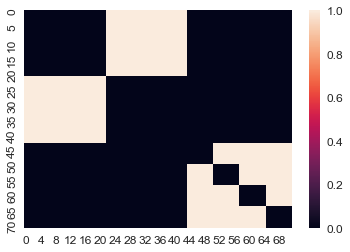

In [12]:
import seaborn as sns

sns.heatmap(mask_self_overlap.astype("int"))

In [13]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_self_ovlp(x, y):
    p = x.copy()
    p[mask_self_overlap] = (y.copy())[mask_self_overlap]
    return p

def embedd_batch_self_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_self_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [33]:
p_embedded_gwh_self_ovlp = embedd_batch_self_ovlp(p_embedded_gwh)

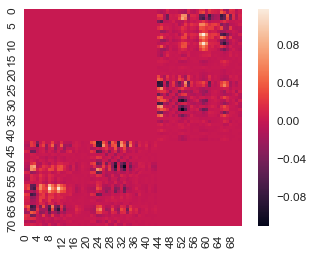

In [34]:
sns.heatmap(p_embedded_gwh_self_ovlp[0] - p_test[0], square=True)

In [35]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_self_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 03:37:55: Iteration calculation: 0
[ ] 2019-01-07 03:37:56: Iteration calculation: 1
[ ] 2019-01-07 03:37:56: Iteration calculation: 2
[ ] 2019-01-07 03:37:58: Iteration calculation: 3
[ ] 2019-01-07 03:37:59: Iteration calculation: 4
[ ] 2019-01-07 03:37:59: Iteration calculation: 5
[ ] 2019-01-07 03:38:00: Iteration calculation: 6
[ ] 2019-01-07 03:38:00: Iteration calculation: 7
[ ] 2019-01-07 03:38:01: Iteration calculation: 8
[ ] 2019-01-07 03:38:02: Iteration calculation: 9
[ ] 2019-01-07 03:38:02: Iteration calculation: 10
[ ] 2019-01-07 03:38:03: Iteration calculation: 11
[ ] 2019-01-07 03:38:03: Iteration calculation: 12
[ ] 2019-01-07 03:38:04: Iteration calculation: 13
[ ] 2019-01-07 03:38:04: Iteration calculation: 14
[ ] 2019-01-07 03:38:05: Iteration calculation: 15
[ ] 2019-01-07 03:38:06: Iteration calculation: 16
[ ] 2019-01-07 03:38:06: Iteration calculation: 17
[ ] 2019-01-07 03:38:07: Iteration calculation: 18
[ ] 2019-01-07 03:38:08: Iteration calcul

[ ] 2019-01-07 03:40:00: Iteration calculation: 160
[ ] 2019-01-07 03:40:01: Iteration calculation: 161
[ ] 2019-01-07 03:40:01: Iteration calculation: 162
[ ] 2019-01-07 03:40:02: Iteration calculation: 163
[ ] 2019-01-07 03:40:02: Iteration calculation: 164
[ ] 2019-01-07 03:40:03: Iteration calculation: 165
[ ] 2019-01-07 03:40:03: Iteration calculation: 166
[ ] 2019-01-07 03:40:04: Iteration calculation: 167
[ ] 2019-01-07 03:40:04: Iteration calculation: 168
[ ] 2019-01-07 03:40:05: Iteration calculation: 169
[ ] 2019-01-07 03:40:06: Iteration calculation: 170
[ ] 2019-01-07 03:40:06: Iteration calculation: 171
[ ] 2019-01-07 03:40:07: Iteration calculation: 172
[ ] 2019-01-07 03:40:08: Iteration calculation: 173
[ ] 2019-01-07 03:40:08: Iteration calculation: 174
[ ] 2019-01-07 03:40:10: Iteration calculation: 175
[ ] 2019-01-07 03:40:11: Iteration calculation: 176
[ ] 2019-01-07 03:40:11: Iteration calculation: 177
[ ] 2019-01-07 03:40:12: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 03:41:58: Iteration calculation: 318
[ ] 2019-01-07 03:41:59: Iteration calculation: 319
[ ] 2019-01-07 03:41:59: Iteration calculation: 320
[ ] 2019-01-07 03:42:00: Iteration calculation: 321
[ ] 2019-01-07 03:42:01: Iteration calculation: 322
[ ] 2019-01-07 03:42:01: Iteration calculation: 323
[ ] 2019-01-07 03:42:02: Iteration calculation: 324
[ ] 2019-01-07 03:42:03: Iteration calculation: 325
[ ] 2019-01-07 03:42:03: Iteration calculation: 326
[ ] 2019-01-07 03:42:04: Iteration calculation: 327
[ ] 2019-01-07 03:42:04: Iteration calculation: 328
[ ] 2019-01-07 03:42:05: Iteration calculation: 329
[ ] 2019-01-07 03:42:05: Iteration calculation: 330
[ ] 2019-01-07 03:42:06: Iteration calculation: 331
[ ] 2019-01-07 03:42:07: Iteration calculation: 332
[ ] 2019-01-07 03:42:07: Iteration calculation: 333
[ ] 2019-01-07 03:42:08: Iteration calculation: 334
[ ] 2019-01-07 03:42:08: Iteration calculation: 335
[ ] 2019-01-07 03:42:09: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 03:44:03: Iteration calculation: 476
[ ] 2019-01-07 03:44:04: Iteration calculation: 477
[ ] 2019-01-07 03:44:04: Iteration calculation: 478
[ ] 2019-01-07 03:44:05: Iteration calculation: 479
[ ] 2019-01-07 03:44:05: Iteration calculation: 480
[ ] 2019-01-07 03:44:07: Iteration calculation: 481
[ ] 2019-01-07 03:44:08: Iteration calculation: 482
[ ] 2019-01-07 03:44:08: Iteration calculation: 483
[ ] 2019-01-07 03:44:09: Iteration calculation: 484
[ ] 2019-01-07 03:44:10: Iteration calculation: 485
[ ] 2019-01-07 03:44:11: Iteration calculation: 486
[ ] 2019-01-07 03:44:11: Iteration calculation: 487
[ ] 2019-01-07 03:44:12: Iteration calculation: 488
[ ] 2019-01-07 03:44:12: Iteration calculation: 489
[ ] 2019-01-07 03:44:13: Iteration calculation: 490
[ ] 2019-01-07 03:44:15: Iteration calculation: 491
[ ] 2019-01-07 03:44:16: Iteration calculation: 492
[ ] 2019-01-07 03:44:17: Iteration calculation: 493
[ ] 2019-01-07 03:44:18: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 03:46:04: Iteration calculation: 634
[ ] 2019-01-07 03:46:04: Iteration calculation: 635
[ ] 2019-01-07 03:46:05: Iteration calculation: 636
[ ] 2019-01-07 03:46:06: Iteration calculation: 637
[ ] 2019-01-07 03:46:06: Iteration calculation: 638
[ ] 2019-01-07 03:46:07: Iteration calculation: 639
[ ] 2019-01-07 03:46:08: Iteration calculation: 640
[ ] 2019-01-07 03:46:08: Iteration calculation: 641
[ ] 2019-01-07 03:46:09: Iteration calculation: 642
[ ] 2019-01-07 03:46:09: Iteration calculation: 643
[ ] 2019-01-07 03:46:11: Iteration calculation: 644
[ ] 2019-01-07 03:46:12: Iteration calculation: 645
[ ] 2019-01-07 03:46:13: Iteration calculation: 646
[ ] 2019-01-07 03:46:14: Iteration calculation: 647
[ ] 2019-01-07 03:46:14: Iteration calculation: 648
[ ] 2019-01-07 03:46:15: Iteration calculation: 649
[ ] 2019-01-07 03:46:17: Iteration calculation: 650
[ ] 2019-01-07 03:46:18: Iteration calculation: 651
[ ] 2019-01-07 03:46:19: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 03:48:02: Iteration calculation: 792
[ ] 2019-01-07 03:48:04: Iteration calculation: 793
[ ] 2019-01-07 03:48:05: Iteration calculation: 794
[ ] 2019-01-07 03:48:06: Iteration calculation: 795
[ ] 2019-01-07 03:48:07: Iteration calculation: 796
[ ] 2019-01-07 03:48:08: Iteration calculation: 797
[ ] 2019-01-07 03:48:09: Iteration calculation: 798
[ ] 2019-01-07 03:48:10: Iteration calculation: 799
[ ] 2019-01-07 03:48:10: Iteration calculation: 800
[ ] 2019-01-07 03:48:11: Iteration calculation: 801
[ ] 2019-01-07 03:48:12: Iteration calculation: 802
[ ] 2019-01-07 03:48:12: Iteration calculation: 803
[ ] 2019-01-07 03:48:13: Iteration calculation: 804
[ ] 2019-01-07 03:48:14: Iteration calculation: 805
[ ] 2019-01-07 03:48:16: Iteration calculation: 806
[ ] 2019-01-07 03:48:16: Iteration calculation: 807
[ ] 2019-01-07 03:48:17: Iteration calculation: 808
[ ] 2019-01-07 03:48:18: Iteration calculation: 809
[ ] 2019-01-07 03:48:19: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 03:50:00: Iteration calculation: 950
[ ] 2019-01-07 03:50:01: Iteration calculation: 951
[ ] 2019-01-07 03:50:02: Iteration calculation: 952
[ ] 2019-01-07 03:50:03: Iteration calculation: 953
[ ] 2019-01-07 03:50:03: Iteration calculation: 954
[ ] 2019-01-07 03:50:04: Iteration calculation: 955
[ ] 2019-01-07 03:50:06: Iteration calculation: 956
[ ] 2019-01-07 03:50:06: Iteration calculation: 957
[ ] 2019-01-07 03:50:07: Iteration calculation: 958
[ ] 2019-01-07 03:50:08: Iteration calculation: 959
[ ] 2019-01-07 03:50:08: Iteration calculation: 960
[ ] 2019-01-07 03:50:09: Iteration calculation: 961
[ ] 2019-01-07 03:50:10: Iteration calculation: 962
[ ] 2019-01-07 03:50:10: Iteration calculation: 963
[ ] 2019-01-07 03:50:12: Iteration calculation: 964
[ ] 2019-01-07 03:50:12: Iteration calculation: 965
[ ] 2019-01-07 03:50:12: Iteration calculation: 966
[ ] 2019-01-07 03:50:13: Iteration calculation: 967
[ ] 2019-01-07 03:50:14: Iteration calculation: 968
[ ] 2019-01-

In [21]:
48/(len(p_test))

0.04795204795204795

# Embedded GWH w/ OFF overlap

In [14]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_off_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i != atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_off_overlap = np.logical_or(mask_off_overlap, m)
    
#mask

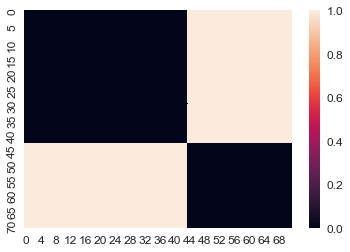

In [15]:
import seaborn as sns

sns.heatmap(mask_off_overlap.astype("int"))

In [16]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_off_ovlp(x, y):
    p = x.copy()
    p[mask_off_overlap] = (y.copy())[mask_off_overlap]
    return p

def embedd_batch_off_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_off_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [40]:
p_embedded_gwh_off_ovlp = embedd_batch_off_ovlp(p_embedded_gwh)

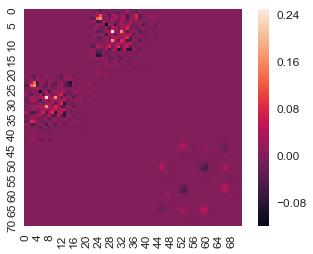

In [41]:
sns.heatmap(p_embedded_gwh_off_ovlp[0] - p_test[0], square=True)

In [42]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_off_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 04:03:15: Iteration calculation: 0
[ ] 2019-01-07 04:03:16: Iteration calculation: 1
[ ] 2019-01-07 04:03:17: Iteration calculation: 2
[ ] 2019-01-07 04:03:18: Iteration calculation: 3
[ ] 2019-01-07 04:03:18: Iteration calculation: 4
[ ] 2019-01-07 04:03:19: Iteration calculation: 5
[ ] 2019-01-07 04:03:20: Iteration calculation: 6
[ ] 2019-01-07 04:03:21: Iteration calculation: 7
[ ] 2019-01-07 04:03:21: Iteration calculation: 8
[ ] 2019-01-07 04:03:22: Iteration calculation: 9
[ ] 2019-01-07 04:03:22: Iteration calculation: 10
[ ] 2019-01-07 04:03:23: Iteration calculation: 11
[ ] 2019-01-07 04:03:23: Iteration calculation: 12
[ ] 2019-01-07 04:03:24: Iteration calculation: 13
[ ] 2019-01-07 04:03:24: Iteration calculation: 14
[ ] 2019-01-07 04:03:25: Iteration calculation: 15
[ ] 2019-01-07 04:03:26: Iteration calculation: 16
[ ] 2019-01-07 04:03:26: Iteration calculation: 17
[ ] 2019-01-07 04:03:27: Iteration calculation: 18
[ ] 2019-01-07 04:03:28: Iteration calcul

[ ] 2019-01-07 04:05:15: Iteration calculation: 160
[ ] 2019-01-07 04:05:16: Iteration calculation: 161
[ ] 2019-01-07 04:05:17: Iteration calculation: 162
[ ] 2019-01-07 04:05:17: Iteration calculation: 163
[ ] 2019-01-07 04:05:18: Iteration calculation: 164
[ ] 2019-01-07 04:05:19: Iteration calculation: 165
[ ] 2019-01-07 04:05:20: Iteration calculation: 166
[ ] 2019-01-07 04:05:20: Iteration calculation: 167
[ ] 2019-01-07 04:05:21: Iteration calculation: 168
[ ] 2019-01-07 04:05:22: Iteration calculation: 169
[ ] 2019-01-07 04:05:23: Iteration calculation: 170
[ ] 2019-01-07 04:05:24: Iteration calculation: 171
[ ] 2019-01-07 04:05:24: Iteration calculation: 172
[ ] 2019-01-07 04:05:25: Iteration calculation: 173
[ ] 2019-01-07 04:05:26: Iteration calculation: 174
[ ] 2019-01-07 04:05:28: Iteration calculation: 175
[ ] 2019-01-07 04:05:29: Iteration calculation: 176
[ ] 2019-01-07 04:05:29: Iteration calculation: 177
[ ] 2019-01-07 04:05:30: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 04:07:12: Iteration calculation: 318
[ ] 2019-01-07 04:07:13: Iteration calculation: 319
[ ] 2019-01-07 04:07:13: Iteration calculation: 320
[ ] 2019-01-07 04:07:14: Iteration calculation: 321
[ ] 2019-01-07 04:07:14: Iteration calculation: 322
[ ] 2019-01-07 04:07:15: Iteration calculation: 323
[ ] 2019-01-07 04:07:15: Iteration calculation: 324
[ ] 2019-01-07 04:07:16: Iteration calculation: 325
[ ] 2019-01-07 04:07:16: Iteration calculation: 326
[ ] 2019-01-07 04:07:17: Iteration calculation: 327
[ ] 2019-01-07 04:07:17: Iteration calculation: 328
[ ] 2019-01-07 04:07:18: Iteration calculation: 329
[ ] 2019-01-07 04:07:18: Iteration calculation: 330
[ ] 2019-01-07 04:07:19: Iteration calculation: 331
[ ] 2019-01-07 04:07:20: Iteration calculation: 332
[ ] 2019-01-07 04:07:20: Iteration calculation: 333
[ ] 2019-01-07 04:07:21: Iteration calculation: 334
[ ] 2019-01-07 04:07:21: Iteration calculation: 335
[ ] 2019-01-07 04:07:22: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 04:09:09: Iteration calculation: 476
[ ] 2019-01-07 04:09:10: Iteration calculation: 477
[ ] 2019-01-07 04:09:10: Iteration calculation: 478
[ ] 2019-01-07 04:09:11: Iteration calculation: 479
[ ] 2019-01-07 04:09:12: Iteration calculation: 480
[ ] 2019-01-07 04:09:12: Iteration calculation: 481
[ ] 2019-01-07 04:09:13: Iteration calculation: 482
[ ] 2019-01-07 04:09:13: Iteration calculation: 483
[ ] 2019-01-07 04:09:14: Iteration calculation: 484
[ ] 2019-01-07 04:09:14: Iteration calculation: 485
[ ] 2019-01-07 04:09:15: Iteration calculation: 486
[ ] 2019-01-07 04:09:15: Iteration calculation: 487
[ ] 2019-01-07 04:09:16: Iteration calculation: 488
[ ] 2019-01-07 04:09:16: Iteration calculation: 489
[ ] 2019-01-07 04:09:17: Iteration calculation: 490
[ ] 2019-01-07 04:09:18: Iteration calculation: 491
[ ] 2019-01-07 04:09:19: Iteration calculation: 492
[ ] 2019-01-07 04:09:20: Iteration calculation: 493
[ ] 2019-01-07 04:09:21: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 04:11:06: Iteration calculation: 634
[ ] 2019-01-07 04:11:07: Iteration calculation: 635
[ ] 2019-01-07 04:11:08: Iteration calculation: 636
[ ] 2019-01-07 04:11:09: Iteration calculation: 637
[ ] 2019-01-07 04:11:10: Iteration calculation: 638
[ ] 2019-01-07 04:11:11: Iteration calculation: 639
[ ] 2019-01-07 04:11:11: Iteration calculation: 640
[ ] 2019-01-07 04:11:12: Iteration calculation: 641
[ ] 2019-01-07 04:11:12: Iteration calculation: 642
[ ] 2019-01-07 04:11:13: Iteration calculation: 643
[ ] 2019-01-07 04:11:14: Iteration calculation: 644
[ ] 2019-01-07 04:11:14: Iteration calculation: 645
[ ] 2019-01-07 04:11:15: Iteration calculation: 646
[ ] 2019-01-07 04:11:15: Iteration calculation: 647
[ ] 2019-01-07 04:11:16: Iteration calculation: 648
[ ] 2019-01-07 04:11:16: Iteration calculation: 649
[ ] 2019-01-07 04:11:18: Iteration calculation: 650
[ ] 2019-01-07 04:11:18: Iteration calculation: 651
[ ] 2019-01-07 04:11:19: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 04:12:59: Iteration calculation: 792
[ ] 2019-01-07 04:13:00: Iteration calculation: 793
[ ] 2019-01-07 04:13:00: Iteration calculation: 794
[ ] 2019-01-07 04:13:01: Iteration calculation: 795
[ ] 2019-01-07 04:13:01: Iteration calculation: 796
[ ] 2019-01-07 04:13:02: Iteration calculation: 797
[ ] 2019-01-07 04:13:02: Iteration calculation: 798
[ ] 2019-01-07 04:13:03: Iteration calculation: 799
[ ] 2019-01-07 04:13:04: Iteration calculation: 800
[ ] 2019-01-07 04:13:04: Iteration calculation: 801
[ ] 2019-01-07 04:13:05: Iteration calculation: 802
[ ] 2019-01-07 04:13:06: Iteration calculation: 803
[ ] 2019-01-07 04:13:06: Iteration calculation: 804
[ ] 2019-01-07 04:13:07: Iteration calculation: 805
[ ] 2019-01-07 04:13:08: Iteration calculation: 806
[ ] 2019-01-07 04:13:09: Iteration calculation: 807
[ ] 2019-01-07 04:13:09: Iteration calculation: 808
[ ] 2019-01-07 04:13:10: Iteration calculation: 809
[ ] 2019-01-07 04:13:10: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 04:14:47: Iteration calculation: 950
[ ] 2019-01-07 04:14:47: Iteration calculation: 951
[ ] 2019-01-07 04:14:48: Iteration calculation: 952
[ ] 2019-01-07 04:14:49: Iteration calculation: 953
[ ] 2019-01-07 04:14:49: Iteration calculation: 954
[ ] 2019-01-07 04:14:50: Iteration calculation: 955
[ ] 2019-01-07 04:14:52: Iteration calculation: 956
[ ] 2019-01-07 04:14:52: Iteration calculation: 957
[ ] 2019-01-07 04:14:53: Iteration calculation: 958
[ ] 2019-01-07 04:14:53: Iteration calculation: 959
[ ] 2019-01-07 04:14:54: Iteration calculation: 960
[ ] 2019-01-07 04:14:55: Iteration calculation: 961
[ ] 2019-01-07 04:14:55: Iteration calculation: 962
[ ] 2019-01-07 04:14:56: Iteration calculation: 963
[ ] 2019-01-07 04:14:58: Iteration calculation: 964
[ ] 2019-01-07 04:14:59: Iteration calculation: 965
[ ] 2019-01-07 04:14:59: Iteration calculation: 966
[ ] 2019-01-07 04:15:00: Iteration calculation: 967
[ ] 2019-01-07 04:15:00: Iteration calculation: 968
[ ] 2019-01-

In [22]:
50/len(p_test)

0.04995004995004995

# Full Matriy SANND

In [17]:
p_full = embedd_batch_off_ovlp(embedd_batch_self_ovlp(embedd_batch(np.zeros(p_test.shape))))

In [18]:
np.mean(np.abs(p_full.flatten() - p_test.flatten()))

0.0

In [19]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_full,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-08 09:17:57: Iteration calculation: 0
[ ] 2019-01-08 09:17:58: Iteration calculation: 1
[ ] 2019-01-08 09:17:58: Iteration calculation: 2
[ ] 2019-01-08 09:17:59: Iteration calculation: 3
[ ] 2019-01-08 09:17:59: Iteration calculation: 4
[ ] 2019-01-08 09:17:59: Iteration calculation: 5
[ ] 2019-01-08 09:18:00: Iteration calculation: 6
[ ] 2019-01-08 09:18:00: Iteration calculation: 7
[ ] 2019-01-08 09:18:00: Iteration calculation: 8
[ ] 2019-01-08 09:18:01: Iteration calculation: 9
[ ] 2019-01-08 09:18:01: Iteration calculation: 10
[ ] 2019-01-08 09:18:02: Iteration calculation: 11
[ ] 2019-01-08 09:18:02: Iteration calculation: 12
[ ] 2019-01-08 09:18:03: Iteration calculation: 13
[ ] 2019-01-08 09:18:03: Iteration calculation: 14
[ ] 2019-01-08 09:18:03: Iteration calculation: 15
[ ] 2019-01-08 09:18:04: Iteration calculation: 16
[ ] 2019-01-08 09:18:04: Iteration calculation: 17
[ ] 2019-01-08 09:18:04: Iteration calculation: 18
[ ] 2019-01-08 09:18:05: Iteration calcul

[ ] 2019-01-08 09:18:59: Iteration calculation: 160
[ ] 2019-01-08 09:19:00: Iteration calculation: 161
[ ] 2019-01-08 09:19:00: Iteration calculation: 162
[ ] 2019-01-08 09:19:01: Iteration calculation: 163
[ ] 2019-01-08 09:19:01: Iteration calculation: 164
[ ] 2019-01-08 09:19:01: Iteration calculation: 165
[ ] 2019-01-08 09:19:02: Iteration calculation: 166
[ ] 2019-01-08 09:19:02: Iteration calculation: 167
[ ] 2019-01-08 09:19:03: Iteration calculation: 168
[ ] 2019-01-08 09:19:03: Iteration calculation: 169
[ ] 2019-01-08 09:19:03: Iteration calculation: 170
[ ] 2019-01-08 09:19:04: Iteration calculation: 171
[ ] 2019-01-08 09:19:04: Iteration calculation: 172
[ ] 2019-01-08 09:19:05: Iteration calculation: 173
[ ] 2019-01-08 09:19:05: Iteration calculation: 174
[ ] 2019-01-08 09:19:05: Iteration calculation: 175
[ ] 2019-01-08 09:19:06: Iteration calculation: 176
[ ] 2019-01-08 09:19:06: Iteration calculation: 177
[ ] 2019-01-08 09:19:06: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-08 09:20:02: Iteration calculation: 318
[ ] 2019-01-08 09:20:02: Iteration calculation: 319
[ ] 2019-01-08 09:20:03: Iteration calculation: 320
[ ] 2019-01-08 09:20:03: Iteration calculation: 321
[ ] 2019-01-08 09:20:04: Iteration calculation: 322
[ ] 2019-01-08 09:20:04: Iteration calculation: 323
[ ] 2019-01-08 09:20:04: Iteration calculation: 324
[ ] 2019-01-08 09:20:05: Iteration calculation: 325
[ ] 2019-01-08 09:20:05: Iteration calculation: 326
[ ] 2019-01-08 09:20:06: Iteration calculation: 327
[ ] 2019-01-08 09:20:06: Iteration calculation: 328
[ ] 2019-01-08 09:20:06: Iteration calculation: 329
[ ] 2019-01-08 09:20:07: Iteration calculation: 330
[ ] 2019-01-08 09:20:07: Iteration calculation: 331
[ ] 2019-01-08 09:20:07: Iteration calculation: 332
[ ] 2019-01-08 09:20:08: Iteration calculation: 333
[ ] 2019-01-08 09:20:08: Iteration calculation: 334
[ ] 2019-01-08 09:20:09: Iteration calculation: 335
[ ] 2019-01-08 09:20:09: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-08 09:21:03: Iteration calculation: 476
[ ] 2019-01-08 09:21:03: Iteration calculation: 477
[ ] 2019-01-08 09:21:04: Iteration calculation: 478
[ ] 2019-01-08 09:21:04: Iteration calculation: 479
[ ] 2019-01-08 09:21:04: Iteration calculation: 480
[ ] 2019-01-08 09:21:05: Iteration calculation: 481
[ ] 2019-01-08 09:21:05: Iteration calculation: 482
[ ] 2019-01-08 09:21:05: Iteration calculation: 483
[ ] 2019-01-08 09:21:06: Iteration calculation: 484
[ ] 2019-01-08 09:21:06: Iteration calculation: 485
[ ] 2019-01-08 09:21:07: Iteration calculation: 486
[ ] 2019-01-08 09:21:07: Iteration calculation: 487
[ ] 2019-01-08 09:21:07: Iteration calculation: 488
[ ] 2019-01-08 09:21:08: Iteration calculation: 489
[ ] 2019-01-08 09:21:08: Iteration calculation: 490
[ ] 2019-01-08 09:21:08: Iteration calculation: 491
[ ] 2019-01-08 09:21:09: Iteration calculation: 492
[ ] 2019-01-08 09:21:09: Iteration calculation: 493
[ ] 2019-01-08 09:21:10: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-08 09:22:05: Iteration calculation: 634
[ ] 2019-01-08 09:22:06: Iteration calculation: 635
[ ] 2019-01-08 09:22:06: Iteration calculation: 636
[ ] 2019-01-08 09:22:07: Iteration calculation: 637
[ ] 2019-01-08 09:22:07: Iteration calculation: 638
[ ] 2019-01-08 09:22:07: Iteration calculation: 639
[ ] 2019-01-08 09:22:08: Iteration calculation: 640
[ ] 2019-01-08 09:22:08: Iteration calculation: 641
[ ] 2019-01-08 09:22:08: Iteration calculation: 642
[ ] 2019-01-08 09:22:09: Iteration calculation: 643
[ ] 2019-01-08 09:22:09: Iteration calculation: 644
[ ] 2019-01-08 09:22:10: Iteration calculation: 645
[ ] 2019-01-08 09:22:10: Iteration calculation: 646
[ ] 2019-01-08 09:22:11: Iteration calculation: 647
[ ] 2019-01-08 09:22:11: Iteration calculation: 648
[ ] 2019-01-08 09:22:12: Iteration calculation: 649
[ ] 2019-01-08 09:22:12: Iteration calculation: 650
[ ] 2019-01-08 09:22:13: Iteration calculation: 651
[ ] 2019-01-08 09:22:13: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-08 09:23:08: Iteration calculation: 792
[ ] 2019-01-08 09:23:08: Iteration calculation: 793
[ ] 2019-01-08 09:23:08: Iteration calculation: 794
[ ] 2019-01-08 09:23:09: Iteration calculation: 795
[ ] 2019-01-08 09:23:09: Iteration calculation: 796
[ ] 2019-01-08 09:23:10: Iteration calculation: 797
[ ] 2019-01-08 09:23:10: Iteration calculation: 798
[ ] 2019-01-08 09:23:11: Iteration calculation: 799
[ ] 2019-01-08 09:23:11: Iteration calculation: 800
[ ] 2019-01-08 09:23:11: Iteration calculation: 801
[ ] 2019-01-08 09:23:12: Iteration calculation: 802
[ ] 2019-01-08 09:23:12: Iteration calculation: 803
[ ] 2019-01-08 09:23:13: Iteration calculation: 804
[ ] 2019-01-08 09:23:13: Iteration calculation: 805
[ ] 2019-01-08 09:23:13: Iteration calculation: 806
[ ] 2019-01-08 09:23:14: Iteration calculation: 807
[ ] 2019-01-08 09:23:14: Iteration calculation: 808
[ ] 2019-01-08 09:23:14: Iteration calculation: 809
[ ] 2019-01-08 09:23:15: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-08 09:24:10: Iteration calculation: 950
[ ] 2019-01-08 09:24:10: Iteration calculation: 951
[ ] 2019-01-08 09:24:11: Iteration calculation: 952
[ ] 2019-01-08 09:24:11: Iteration calculation: 953
[ ] 2019-01-08 09:24:12: Iteration calculation: 954
[ ] 2019-01-08 09:24:12: Iteration calculation: 955
[ ] 2019-01-08 09:24:12: Iteration calculation: 956
[ ] 2019-01-08 09:24:13: Iteration calculation: 957
[ ] 2019-01-08 09:24:13: Iteration calculation: 958
[ ] 2019-01-08 09:24:13: Iteration calculation: 959
[ ] 2019-01-08 09:24:14: Iteration calculation: 960
[ ] 2019-01-08 09:24:14: Iteration calculation: 961
[ ] 2019-01-08 09:24:15: Iteration calculation: 962
[ ] 2019-01-08 09:24:15: Iteration calculation: 963
[ ] 2019-01-08 09:24:16: Iteration calculation: 964
[ ] 2019-01-08 09:24:16: Iteration calculation: 965
[ ] 2019-01-08 09:24:16: Iteration calculation: 966
[ ] 2019-01-08 09:24:17: Iteration calculation: 967
[ ] 2019-01-08 09:24:17: Iteration calculation: 968
[ ] 2019-01-